# Binary stars evolutions and binary black holes

Giacomo Menegatti, Dario Puggioni, Laura Schulze, Savina Tsichli

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("darkgrid")
import regex as re
from scipy.stats import pointbiserialr, spearmanr
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

## Loading the dataset
The dataset is divided in files depending on the CE efficiency $ \alpha $ and the metallicity $ Z $ of the two stars. All the data are loaded into a pandas dataframe containing also the two parameters.


In [2]:
alpha = [0.5, 1, 3, 5] # CE efficiency
Z = [2e-4, 4e-4, 8e-4, 1.2e-3, 1.6e-3, 2e-3, 4e-3, 6e-3, 8e-3, 1.2e-2, 1.6e-2, 2e-2]  #Metallicity value

data = [] #Data list 

sim_data = pd.DataFrame({'alpha':[], 'Z':[], 'MtotZAMS':[], 'num_mergers':[]})
#Appending all the values in a single big dataframe

index = 0
for a in alpha:
    for m in Z:
        # The simulation data first row contains the MtotZAMS and the number of merger for each alpha and metallicity 
        df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', sep=' ', nrows = 1, header=0) 
        sim_data.loc[index] = [a, m, df.iloc[0,0], df.iloc[0,1]]  #Adding the row to the sim_data df
        index = index + 1 
    
        df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', header=2, sep= ' ')     # Simulation data
        df['alpha'],df['Z'] = a, m                                 #Adding the alpha and Z paramtere in the table
        
        data.append(df)

data = pd.concat(data)
data.columns = [re.sub('col.*:|/.*$', '', name) for name in data.columns]

In [3]:
data.columns.values[9] = 'kick_1'
data.columns.values[10] = 'kick_2'

print('Data columns: \n ', data.columns.values)
data.reset_index(drop=True,inplace=True)
data

Data columns: 
  ['ID' 'm1ZAMS' 'm2ZAMS' 'm1rem' 'm2rem' 'm1rem+m2rem' 'delay_time' 'sma'
 'ecc' 'kick_1' 'kick_2' 'cmu1' 'cmu2' 'v1x' 'v1y' 'v1z' 'v2x' 'v2y' 'v2z'
 'time_SN1' 'time_SN2' 'CE' 'alpha' 'Z']


,ID,m1ZAMS,m2ZAMS,m1rem,m2rem,m1rem+m2rem,delay_time,sma,ecc,kick_1,...,v1y,v1z,v2x,v2y,v2z,time_SN1,time_SN2,CE,alpha,Z
0,0_710,24.1323,17.1893,9.5692,5.0020,14.5712,141.1783,5.1703,0.258940,69.1458,...,-14.2600,12.3200,159.00,14.410,-16.0800,8.826,13.340,True,0.5,0.0002
1,0_1044,69.5474,64.3689,28.4847,39.1186,67.6033,9.2023,6.4328,0.055966,0.0000,...,0.0000,-0.0000,33.43,0.000,0.0000,4.270,5.594,True,0.5,0.0002
2,0_1205,106.6977,41.0318,39.9392,38.2094,78.1486,2223.2639,35.8880,0.041435,0.0000,...,0.0000,0.0000,13.65,-0.000,-0.0000,3.722,6.271,False,0.5,0.0002
3,0_1289,74.3594,54.3256,30.1523,37.4020,67.5543,8.7628,6.0720,0.041342,0.0000,...,0.0000,0.0000,26.89,0.000,-0.0000,4.163,5.917,True,0.5,0.0002
4,0_1702,116.6000,63.2642,41.9604,42.9817,84.9421,2636.2197,40.0410,0.079504,0.0000,...,0.0000,-0.0000,25.05,0.000,-0.0000,3.645,5.581,False,0.5,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963577,4_2568032,49.5343,41.7016,4.9807,4.6760,9.6567,10772.9297,11.8280,0.251980,57.0372,...,-4.5470,-12.3800,106.80,-11.690,-4.2940,4.938,5.526,True,5.0,0.0200
2963578,4_2625808,89.2801,62.1861,7.3304,5.1195,12.4499,16.0614,462.4200,0.999370,25.5971,...,-0.4379,7.7350,31.54,-1.229,0.1420,4.100,4.566,True,5.0,0.0200
2963579,4_3141067,36.4361,27.1551,4.0565,3.2400,7.2965,2200.2712,212.1500,0.993170,44.3295,...,-1.7630,2.3040,57.32,-25.490,2.6910,5.870,8.173,True,5.0,0.0200
2963580,4_3486012,73.1220,37.7591,8.2607,4.8831,13.1438,6547.9141,302.6300,0.988970,18.3612,...,1.4470,-0.7723,40.58,-8.732,2.6860,4.282,6.396,True,5.0,0.0200


In [4]:
CE_data = data.query('CE == True')
MT_data = data.query('CE == False')
print(f'CE_data shape={CE_data.shape}, MT_data shape={MT_data.shape}')

print(f'There are {CE_data.shape[0]} BBHs evolving from common envelope, and {MT_data.shape[0]} BBHs evolving from mass transfer')
s_data = data.sample(n=150000, random_state=42)  # A smaller datafreme picking random data, 150k rows above 2.96 millions
s_CE_data = s_data.query('CE == True')
s_MT_data = s_data.query('CE == False')

CE_data shape=(2551001, 24), MT_data shape=(412581, 24)
There are 2551001 BBHs evolving from common envelope, and 412581 BBHs evolving from mass transfer


In [5]:
#sns.scatterplot(data.query('alpha==0.5 and Z == 2e-4'), x='m1rem/Msun', y='m2rem/Msun', hue = 'CE', markers='.')



In [6]:
numeric_columns = [col for col in data.columns if col != 'CE' and col != 'ID']

correlation_df = pd.DataFrame(columns=['Feature', 'Spearman_Correlation','Biserial_Correlation'])
correlation_data = []
for column in numeric_columns:
    spearman_corr, _ = spearmanr(data['CE'], data[column])
    biserial_corr, _ = pointbiserialr(data['CE'], data[column])
    correlation_data.append({'Feature':column,'Spearman_Correlation':spearman_corr,'Biserial_Correlation':biserial_corr})
correlation_df = pd.DataFrame(correlation_data)
correlation_df

#I don't know well these two parameters, but the Spearman correlation is used to see how tho continues variables correlate monotonically
#It ranges in the interval [-1,+1], where -1 indicates a perfect decrescent correlation, 0 indicates no correlation and +1 indicates 
#a perfect crescent correlation. But we don't have two continues variables, so I adapted with values 0 and 1. The biserial correlation
#is more specific for our case, but maybe it works only for a correlation of the linear type, but I don't know what does it mean in the binary case,
#so maybe the biserial_correlation is more correct. Anyway these two statisctical indicators give us similar values.

,Feature,Spearman_Correlation,Biserial_Correlation
0,m1ZAMS,-0.451550,-0.462425
1,m2ZAMS,-0.124183,-0.065608
2,m1rem,-0.432684,-0.450506
3,m2rem,-0.315928,-0.306382
4,m1rem+m2rem,-0.377908,-0.383408
5,delay_time,-0.286209,-0.220924
6,sma,-0.451341,-0.028308
7,ecc,0.292454,0.215878
8,kick_1,0.351001,0.254945
9,kick_2,0.278179,0.202675


In [7]:
correlation_dict = {}
for column in numeric_columns:
    correlation = data[column].corr(data['CE'])
    correlation_dict[column] = correlation
correlation_dict=pd.DataFrame(correlation_dict,index=['Correlation']).T
correlation_dict.sort_values(by='Correlation',key=abs,ascending=False)


,Correlation
m1ZAMS,-0.462425
m1rem,-0.450506
time_SN1,0.396096
m1rem+m2rem,-0.383408
m2rem,-0.306382
kick_1,0.254945
time_SN2,0.251870
delay_time,-0.220924
ecc,0.215878
kick_2,0.202675


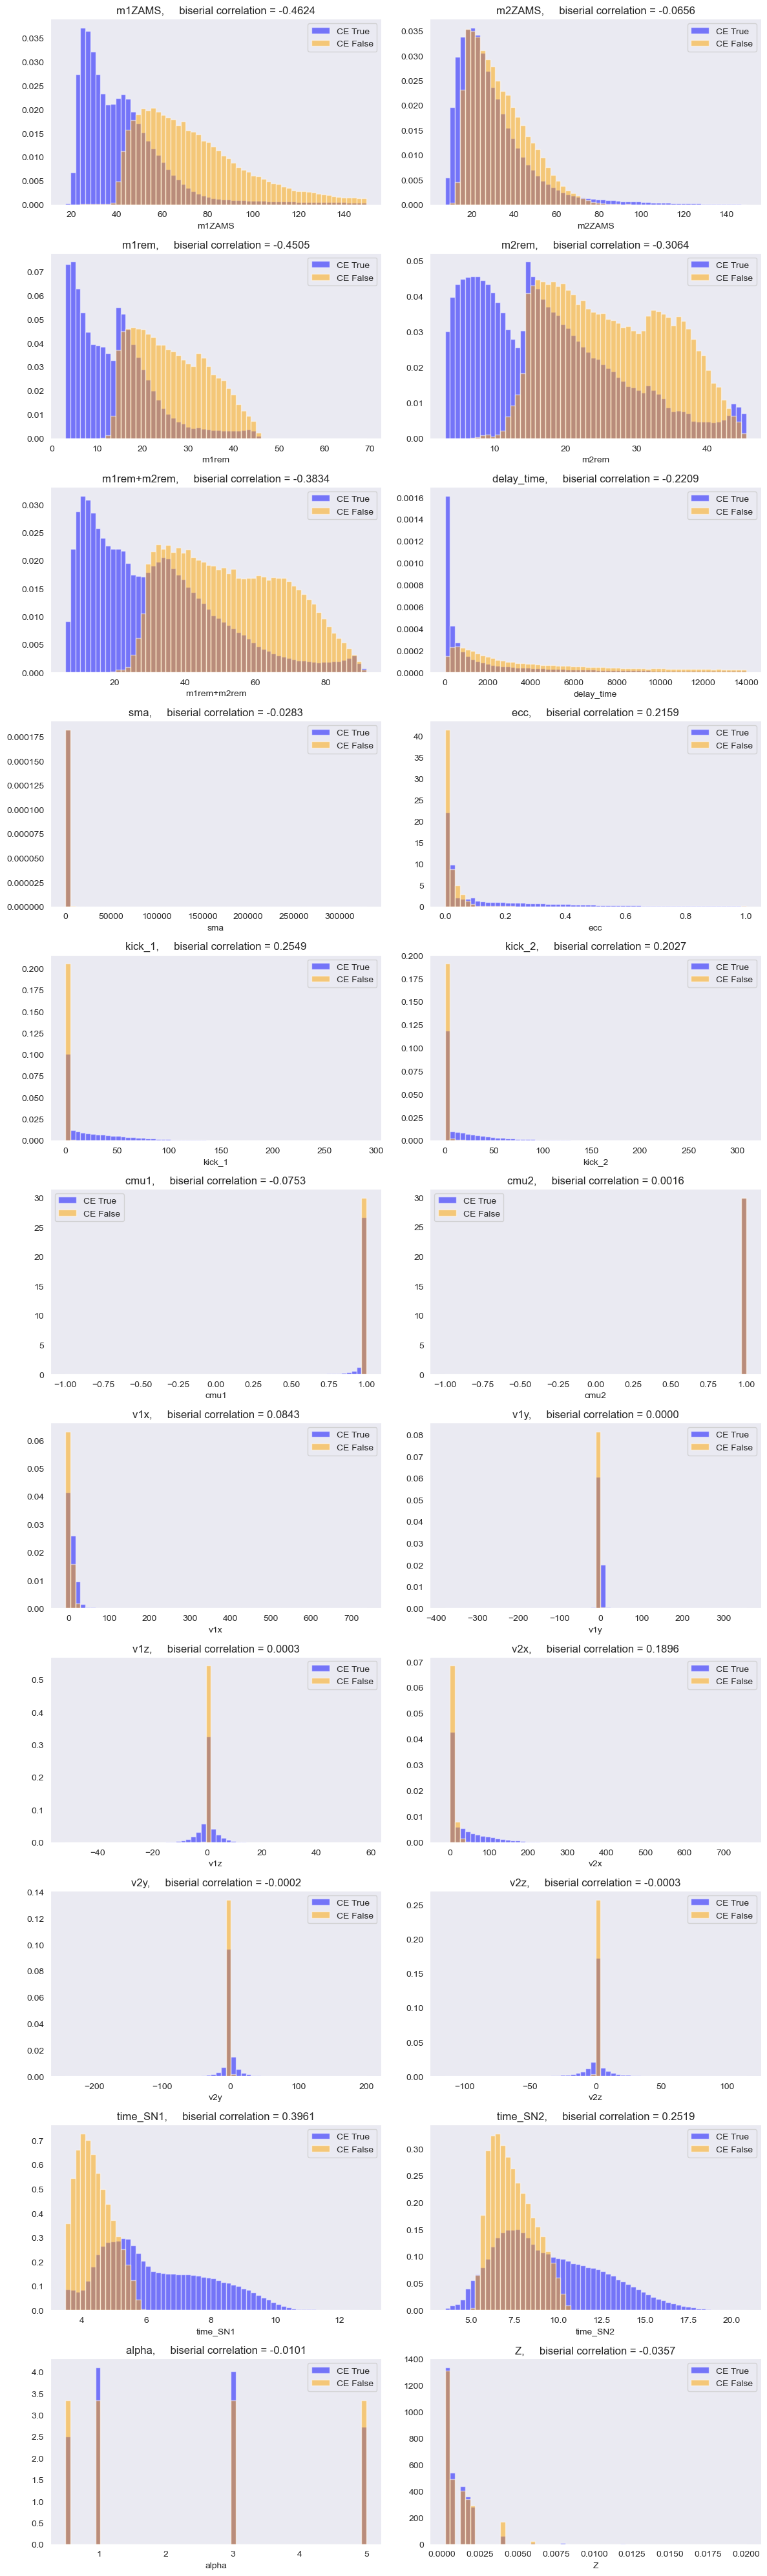

In [8]:
numeric_columns = [col for col in data.columns if col != 'CE' and col != 'ID']
fig, axs = plt.subplots(nrows=11, ncols=2, figsize=(12, 40))
for i, col in enumerate(numeric_columns):
    ax = axs[i//2, i%2] 
    data[data.CE == True][col].hist(bins=60,range=(data[col].min(), data[col].max()), color='blue', alpha=0.5, label='CE True', ax=ax,density=True)
    data[data.CE == False][col].hist(bins=60, range=(data[col].min(), data[col].max()),color='orange', alpha=0.5, label='CE False', ax=ax,density=True)
    ax.grid(None)
    ax.legend(loc='best')
    ax.set_xlabel(col)
    ax.set_title(f'{col},     biserial correlation = {correlation_df.Biserial_Correlation[i]:.4f}')


plt.tight_layout()
plt.show()


##For example, for column m1ZAMS, the biserial correlation is ~-0.46. In the histogram we see that lower values favor the condition 'True', 
#while higher value favor the condition 'False'. For the column 'v1z' the biserial correlation is ~0.0003, that means no correlation. We can see 
#in the histogram that data are equally distributed for both conditions.

## Investigating parameter importance through Machine Learning

To Do: 
- maybe a different section title
- potentially remove the training time? It's somewhat unnecessary
- modify comments
- maybe add a more direct comparison of the different importance results
- should we directly include the descriptions of the tasks we were given?

### Training the Random Forest Model
The Random Forest was implemented using the `RandomForestClassifier` from the sklearn.ensemble module.

In [9]:
# prepare data X and labels y
# drop ID column
X = data.drop(columns=['ID', 'CE'])
y = data['CE']

# split data into training and test set (10% to 90%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9, random_state=100)

In [10]:
# initialise random forest classifier
# using n_jobs=-1 to run parallel jobs using all processors
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# let's time this for fun
ts = time.time()
clf.fit(X_train, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

Training time: 49.13 s
Training accuracy:  1.0
Test accuracy:  0.9984114570054858


### Analyzing feature importance

To Do: Add a **SHORT** description of the used feature importance metrics

#### Gini importance
The Gini importances are available through the `feature_importances_`-attribute of the `RandomForestClassifier`.

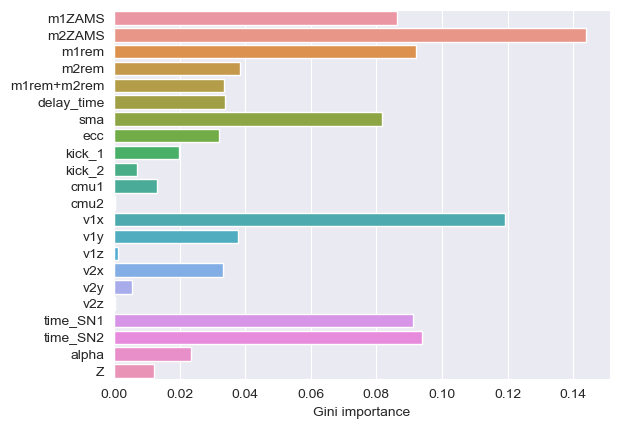

,param,gini
0,m1ZAMS,0.086421
1,m2ZAMS,0.144062
2,m1rem,0.091984
3,m2rem,0.038429
4,m1rem+m2rem,0.033413
5,delay_time,0.033703
6,sma,0.081828
7,ecc,0.032007
8,kick_1,0.019944
9,kick_2,0.007136


In [11]:
# save params + importances to dataframe
importances = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_),
                           columns=["param", "gini"])

# sort importances
#importances = importances.sort_values(by="gini", ascending= False)

# plot importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='gini', data=importances, ax=ax)
#ax.tick_params(axis='x', rotation=90) #for params on x and gini on y
ax.set_ylabel('')
ax.set_xlabel('Gini importance')
plt.show()
importances

#### Permutation Feature Importance
The permutation feature importances were calculated with the test data set using the `sklearn.inspection.permutation_importance` method.

In [12]:
# compute permutation feature importances
# warning: takes a lot of time to compute!
ts = time.time()
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
print("importance calculation time: {:.2f} s".format(time.time() - ts))

importance calculation time: 3275.94 s


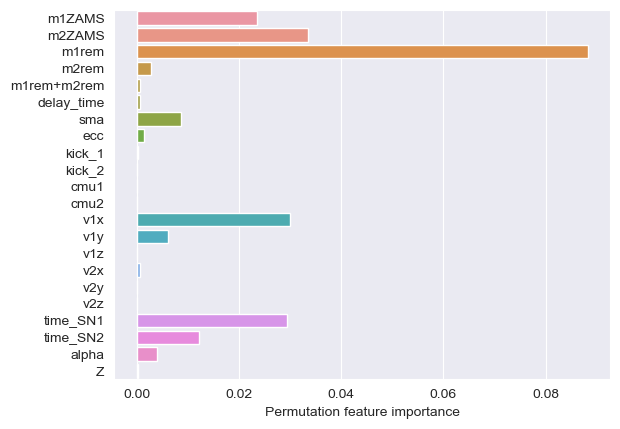

In [13]:
importances['permutation'] = result.importances_mean

# plot importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='permutation', data=importances, ax=ax)
#ax.tick_params(axis='x', rotation=90) #for params on x and importance on y
ax.set_ylabel('')
ax.set_xlabel('Permutation feature importance')
plt.show()

In [14]:
importances

,param,gini,permutation
0,m1ZAMS,0.086421,0.023518
1,m2ZAMS,0.144062,0.033555
2,m1rem,0.091984,0.088200
3,m2rem,0.038429,0.002718
4,m1rem+m2rem,0.033413,0.000641
5,delay_time,0.033703,0.000710
6,sma,0.081828,0.008716
7,ecc,0.032007,0.001333
8,kick_1,0.019944,0.000230
9,kick_2,0.007136,-0.000005


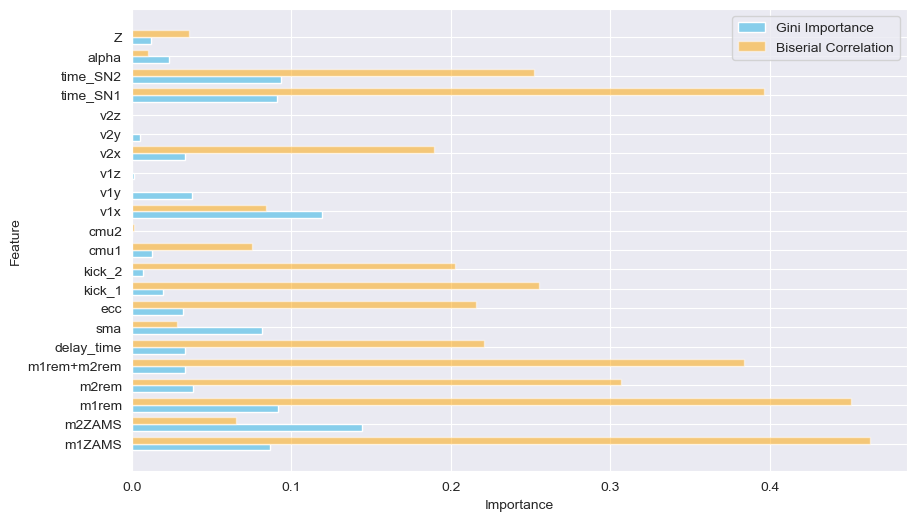

In [19]:
bar_width=0.35
fig, ax = plt.subplots(figsize=(10, 6))

index = np.arange(len(correlation_df))

ax.barh(index, importances['gini'], color='skyblue',  height=bar_width,label='Gini Importance')

ax.barh(index + bar_width, np.abs(correlation_df['Biserial_Correlation']), color='orange', alpha=0.5, height=bar_width, label='Biserial Correlation')

ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(correlation_df['Feature'])

ax.legend()

plt.show()